#Dask Tutorial: performing NDVI

Dask is a python API which allows for scalable paralellization and distributed computation. It is built in Python and integrates well with other common Python API's you might be familiar with like Pandas, Scikit-learn, and Numpy. Dask allows scalability with these common python APIs.

Uses cases for Dask, this piece of the documentation goes through diferent uses for Dask and examples: https://docs.dask.org/en/latest/use-cases.html

For this tutorial we will be working through a simple function using Dask arrays to perform NDVI on a geotiff file by breaking up our large dataset and performing the computation simultaneously on different chunks of the data. 

***What is distributed computation and why use Dask?***  
Distributed computation means that the computing for your program is coordinated on a system whose components are located on different networked computers, which communicate and coordinate their actions by passing messages to one another.

Dask can be used to analyze large datasets for example: Numpy, Pandas dataframes, and lists. The datasets can be dask arrays, dask datasets or dask bags. It can also be used for custom task scheduling, if you are doing a computation of many functions that rely on eachother it can be used to schedule distributed compuation. 

There are also many options with dask to achieve different types of parallelism. A brief overview: 

*   Single machine parallelism with threads or processes: the Dask single-machine scheduler leverages the full CPU power of a laptop or a large workstation and changes the space limitation from “fits in memory” to “fits on disk”. 

*   Distributed cluster parallelism on multiple nodes: the Dask distributed scheduler coordinates the actions of multiple machines on a cluster. It scales anywhere from a single machine to a thousand machines, but not significantly beyond




In [0]:
#Run this cell so we are able to use Dask
import dask

##Step one: Connect to your google drive
The easiest way to use huge files in google collabratory is to connect to your google drive folder structure. It is also possible to upload files from your computer to google collabratory, but since we are working with very larger geotiffs, it takes a long time. 

First, make sure that you change your Runtime to GPU. In the top of the notebook, pull down Runtime. Click Change runtime type. Change the hardware accelerator to GPU. 

This will give you more memory in Collab.

In [0]:
#Run this cell and open the URL, authorize google drive, and copy the authorization code.
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Run this cell to test that you have connected successfully
with open('/content/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/gdrive/My\ Drive/foo.txt

Hello Google Drive!

In [0]:
#Create a variable to hold the tif file and write the file path where the tif is located in your google drive
tile = '/content/gdrive/My Drive/2017 Tiles/m_4709159_sw_15_1_20171010.tif'

##Step two: Reading the with Rasterio and Viewing with Matplotlib 
Rasterio is very helpful for reading geotiff files as numpy arrays. We will use rasterio to reach each band of the geotiff file and visualize them using Matplolib

Later, we will use the bands from our geotiff to do a computation using Dask. The first step is reading our arrays as dask arrays, so it's important to use something like rasterio (or gdal) to read our geotiff bands as arrays. 

In [0]:
#Google Colab neeeds to install rasterio to use the package
!pip install rasterio

    100% |████████████████████████████████| 19.7MB 2.8MB/s 


In [0]:
import rasterio
from rasterio.plot import show

In [0]:
#First, we creat a variable, img, and use rasterio to open the tile from google drive
img = rasterio.open(tile)

#Checking the width and height of the raster tells us the dimensions of the cell grid that makes up the raster
print("array width is",img.width)
print("array height is",img.height)

#Check the number of bands, we will use band 3 and 4 for NDVI

print("the number of bands in the geotiff is",img.indexes)

array width is 5464
array height is 7625
the number of bands in the geotiff is (1, 2, 3, 4)


In [0]:
#Create variables for each band of the geotiff
band1 = img.read(1)
band2 = img.read(2)
band3 = img.read(3)
band4 = img.read(4)

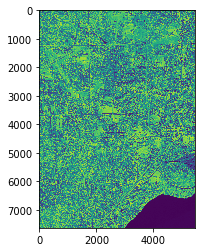

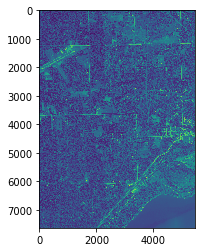

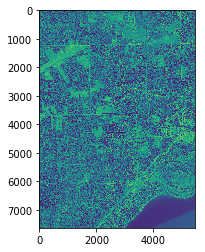

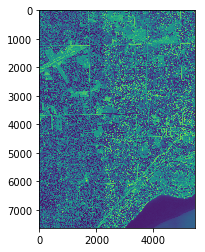

In [0]:
#Plot the different bands to see what they look like
show(band4)
show(band3)
show(band2)
show(band1)

##Step 3 Perform NDVI with Dask Arrays

The function below is a simple function that takes in two parameters and calculates NDVI (Normalized difference vegetation index). NDVI is graphical indicator used in remote sensing to asses if the target in the remotely sensed image (what we see as our geotiff) contains live green vegetation.

The parameters we want to give to this function are Dask Arrays. **Dask Arrays** implement Numpy ndarray interface, which we are familiar with. Dask arrays cut up large arrays into smaller arrays which allows the user to compute on arrays larger than the memory on all of the cores available. The algorithm that allows for the computation on large arrays is coordindate by Dask graphs.

Documentation on Dask arrays: http://docs.dask.org/en/latest/array.html

In [0]:
#Function for calculating NDVI (Normalized difference vegetation index)
def ndvi(band3,band4):
  ndvi = ((band4-band3)/(band4+band3))
  return(ndvi)

###Dask Arrays
Converting your geotiff to a Dask Array makes your tiff a Numpy Array, but with the addition of dask the benefit is that you are able to "Chunk" the array. 

 **Chunks**
Chunks define how dask will break up the array. For example, if you decide chunks=(1000,1000), the cells will be dividied into 1000x1000 chunks. 

In [0]:
import dask.array as da

#Using from_array in this cell allows us to create a variable that takes band 3 in 1000x1000 cell sized chunks
dband3 = da.from_array(band3, chunks=(1000,1000))
dband4 = da.from_array(band4, chunks=(1000,1000))

In [0]:
#First, let's see how long it takes to calculated NDVI on our raster without any paralellization
%%time
NDVI = ((dband4-dband3)/(dband4+dband3))

CPU times: user 2.97 ms, sys: 9.97 ms, total: 12.9 ms
Wall time: 12.5 ms


###Dask map_blocks vs map_overlap

The purpose of using a mapping function in dask is to perform the computation simultaneously on different sections of the array.

map_blocks:  maps a function across all blocks of a dask array.
map_overlap: maps a function over blocks of the array with some overlap

map_overlap and map_blocks example documentation: https://docs.dask.org/en/latest/array-overlap.html?highlight=map_overlap

For our NDVI calculation, we will parallelize the NDVI computation across the array by using map_blocks to apply the function across the blocks of the array, which are the chunks. The chunks decide how big the blocks are.

###Scheduling
The purpose of the dask schedulers is so that you can execute your code on parallel hardware. The different types of schedulers will assign the parallel computations. Dask Documentation: https://docs.dask.org/en/latest/scheduling.html

Dask has two families of schedulers: single machine schedulers and distributed schedulers. For this project we will be using single machine schedulers

The single process schedulers are** local process** or **thread**. 

*Threads* use shared memory and *local processes* have different memory spaces.  

*   The benefit of threads is that with a shared memory space it is easy for threads to communicate between eachother and the downside is potential collision or errors.
*   The benefit of local processes is having separate memory spaces.  

Use the cell below to experiment with different schedulers and different chunks sizes, noting time differences.



In [0]:
%%time

#Using map_blocks to do ndvi function, play with different chunk sizes 
f = da.map_blocks(ndvi, dband3, dband4, dtype='uint16', chunks=(1000,1000)) 

#Use .compute() to compute and set the scheduler to 'threads' or 'processes'
f.compute(scheduler='threads')

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.72 GB -- Worker memory limit: 2.00 GB
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 1.72 GB -- Worker memory limit: 2.00 GB


CPU times: user 371 ms, sys: 38.1 ms, total: 410 ms
Wall time: 290 ms


##Download the NDVI Array as an hdf5 file
hdf5 is a data model that is meant to represent very large or complex data objects. It can be a very useful data format. For exporting dask arrays from collabratory it's easy to use h5py to create a hdf5 file and then download the file onto your local computer with google.colab

In [0]:
 import h5py

#Output the NDVI array to a hdf5 file with h5py
h5f = h5py.File('NDVIarr.hdf5', 'w')
h5f.create_dataset('dataset', data=f)
h5f.close()

#Download the file to your computer
from google.colab import files 
files.download('NDVIarr.hdf5')